## Reading Genotypes

In [2]:
fp = open("CCGenotypes.csv", 'r')
data = fp.read().split('\n')        # break file into lines
fp.close()
header = data.pop(0).split(',')     # First line is header
while (len(data[-1].strip()) < 1):  # remove extra lines
    data.pop()
for i, line in enumerate(data):     # make a list from each row
    field = line.split(',')
    field[1] = int(field[1])        # convert position to integer
    data[i] = field
fp.close()

print(header)
print("Number of probes", len(data))
for i in range(100,110):
    print("data[%d] = %s" % (i, data[i]))

['Chromosome', 'Position', 'A/J', 'C57BL/6J', '129S1/SvImJ', 'NOD/ShiLtJ', 'NZO/HlLtJ', 'CAST/EiJ', 'PWK/PhJ', 'WSB/EiJ', 'CC004/TauUnc']
Number of probes 417
data[100] = ['1', 58523233, 'T', 'T', 'T', 'T', 'C', 'C', 'C', 'T', 'T']
data[101] = ['1', 59995627, 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C', 'C']
data[102] = ['1', 60400655, 'A', 'A', 'A', 'G', 'G', 'G', 'A', 'G', 'G']
data[103] = ['1', 60761817, 'G', 'G', 'G', 'A', 'A', 'A', 'G', 'G', 'G']
data[104] = ['1', 61312969, 'C', 'C', 'C', 'C', 'C', 'C', 'T', 'C', 'C']
data[105] = ['1', 62719241, 'A', 'G', 'A', 'A', 'A', 'A', 'G', 'A', 'A']
data[106] = ['1', 63003989, 'T', 'T', 'T', 'T', 'T', 'C', 'C', 'C', 'C']
data[107] = ['1', 64378809, 'G', 'A', 'G', 'G', 'G', 'G', 'A', 'G', 'G']
data[108] = ['1', 64700440, 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
data[109] = ['1', 65504911, 'C', 'T', 'C', 'C', 'T', 'C', 'C', 'C', 'C']


## Emission Probabilites based on Genotypes

In [3]:
i = int(input("Enter locus [0, %d] to see its Emission probability:" % len(data)))

print(data[i])
Nstates = 8
ErrorRate = 0.05
# Count expected genotypes
count = dict([(call, data[i][2:2+Nstates].count(call)) for call in "ACGTHN"])
print("          ", ', '.join(["%8s" % v[0:8] for v in header[2:2+Nstates]]))
for base in count.keys():
    # Compute emission probability, assuming 5% error rate
    if (count[base] == 0):
        emission = [1.0/Nstates for j in range(2,2+Nstates)]   # unexpected 
    else:
        emission = [(1.0 - ErrorRate)/count[base] if data[i][j] == base else ErrorRate/(Nstates - count[base])
                    for j in range(2,2+Nstates)]
    emission = ["%6.4f" % v for v in emission]
    print("    %s: %2d %s" % (base, count[base], emission))

Enter locus [0, 417] to see its Emission probability:100
['1', 58523233, 'T', 'T', 'T', 'T', 'C', 'C', 'C', 'T', 'T']
                A/J, C57BL/6J, 129S1/Sv, NOD/ShiL, NZO/HlLt, CAST/EiJ,  PWK/PhJ,  WSB/EiJ
    A:  0 ['0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250']
    C:  3 ['0.0100', '0.0100', '0.0100', '0.0100', '0.3167', '0.3167', '0.3167', '0.0100']
    G:  0 ['0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250']
    T:  5 ['0.1900', '0.1900', '0.1900', '0.1900', '0.0167', '0.0167', '0.0167', '0.1900']
    H:  0 ['0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250']
    N:  0 ['0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250', '0.1250']


## Transition probabilities

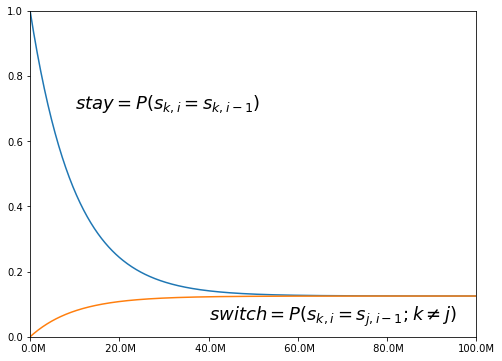

In [4]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plot

fig = plot.figure(figsize = (8,6))
axes = fig.add_subplot(111)

Nstates = 8
scale = 10000000.0
x = numpy.arange(0,100000000.0,200000.0)
stay = ((Nstates - 1.0) * numpy.exp(-x/scale) + 1.0) / Nstates 
switch = (1.0 - stay) / (Nstates - 1.0)

plot.plot(x, stay, x, switch)
plot.text(10000000, 0.7, r'$stay = P(s_{k,i} = s_{k,i-1})$', size="18")
plot.text(40000000, 0.05, r'$switch = P(s_{k,i} = s_{j,i-1}; k \neq j)$', size="18")
plot.xlim((0,100000000.0))
plot.ylim((0,1.0))
pos, labels = plot.xticks()
result = plot.xticks(pos, ["%5.1fM" % (p/1000000) for p in pos])

## Viterbi Algorithm as a Dynamic Program

In [5]:
from math import exp, log10

Nstates = 8
prevpos = 1
state = [[(float(len(data)),i) for i in range(Nstates)]]   # (log(p), PathToHere)
for i in range(len(data)):
    # Count expected genotypes
    count = dict([(call, data[i][2:2+Nstates].count(call)) for call in "ACGTHN"])
    # Get the target genotype at this probe
    observed = data[i][-1]
    # Compute emission probability, assuming 5% error rate
    if (count[observed] == 0):
        emission = [1.0/Nstates for j in xrange(2,2+Nstates)]   # unexpected 
    else:
        emission = [0.95/count[data[i][j]] if data[i][j] == observed else 0.05/(Nstates - count[data[i][j]])
                    for j in range(2,2+Nstates)]
    # compute transition probability
    position = data[i][1]
    delta = position - prevpos
    prevpos = position
    stay = ((Nstates - 1.0)*exp(-delta/10000000.0) + 1.0)/Nstates
    switch = (1.0 - stay)/(Nstates - 1.0)
    # update state probailities for all paths leading to the ith state
    path = []
    for j in range(Nstates):
        choices = [(log10(emission[j])+(log10(stay) if (k==j) else log10(switch))+state[-1][k][0],k)
                   for k in range(Nstates)]
        path.append(max(choices))   # choices is a list of tuples of (score[i], from_whence_I_arrived[i])
    state.append(path)
print("Length of paths:", len(state))

Length of paths: 418


## Backtrack to find solution

In [6]:
# backtrack
path = state[-1]
maxi = 0
maxp = path[0][0]
for i in range(1,Nstates):
    if (path[i][0] > maxp):
        maxp = path[i][0]
        maxi = i
print(maxi, path[maxi], header[2+maxi])

for j in range(len(state)-2,-1,-1):
    data[j].append(header[2+maxi])
    maxi = state[j+1][maxi][1]

header.append("Founder")
fp = open("result.csv", 'w')
fp.write(','.join(header)+'\n')
prev = ''
for row in data:
    line = ','.join([str(v) for v in row])
    fp.write(line+'\n')
    if (row[-1] != prev):
        print(line)
        prev = row[-1]
print(line)
fp.close()

5 (129.58171061177885, 5) CAST/EiJ
1,3409090,C,C,A,A,C,A,A,A,A,PWK/PhJ
1,14334166,A,G,A,A,A,G,G,G,A,129S1/SvImJ
1,41477940,G,A,A,A,A,G,G,G,G,A/J
1,52869070,G,G,G,A,A,G,G,A,A,WSB/EiJ
1,67749123,A,G,A,A,A,G,G,G,A,A/J
1,132786434,C,C,C,C,C,T,C,C,C,C57BL/6J
1,172685919,A,G,A,A,A,G,G,G,A,A/J
1,176074355,A,G,G,G,A,G,A,A,G,CAST/EiJ
1,194886567,G,G,T,G,T,T,G,T,T,CAST/EiJ


In [7]:
!head result.csv; echo '...'; tail result.csv

Chromosome,Position,A/J,C57BL/6J,129S1/SvImJ,NOD/ShiLtJ,NZO/HlLtJ,CAST/EiJ,PWK/PhJ,WSB/EiJ,CC004/TauUnc,Founder
1,3409090,C,C,A,A,C,A,A,A,A,PWK/PhJ
1,3427467,A,A,A,A,A,G,G,A,G,PWK/PhJ
1,3439034,C,C,T,T,C,C,C,T,C,PWK/PhJ
1,3668628,A,G,G,G,G,A,A,G,A,PWK/PhJ
1,4504223,G,G,G,G,G,A,G,A,G,PWK/PhJ
1,4744395,T,T,T,T,T,G,T,G,T,PWK/PhJ
1,5069641,A,A,A,A,A,G,A,A,A,PWK/PhJ
1,5149169,T,G,T,G,T,G,T,T,T,PWK/PhJ
1,7698048,A,G,A,A,A,G,G,G,G,PWK/PhJ
...
1,193654902,G,A,A,G,A,G,G,G,G,CAST/EiJ
1,193673297,G,A,A,G,A,G,G,G,G,CAST/EiJ
1,193688845,A,C,C,A,C,C,A,A,C,CAST/EiJ
1,193709621,G,A,A,A,A,A,G,G,A,CAST/EiJ
1,193732571,T,C,C,C,C,C,T,C,C,CAST/EiJ
1,193928056,A,G,G,A,G,A,A,A,A,CAST/EiJ
1,194000258,C,C,C,T,C,C,C,T,C,CAST/EiJ
1,194149219,G,A,A,G,G,G,G,G,G,CAST/EiJ
1,194625219,C,T,T,T,C,T,T,C,T,CAST/EiJ
1,194886567,G,G,T,G,T,T,G,T,T,CAST/EiJ
